In [192]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

<h1> Prepare data </h1>

<h5> Load Excel file as dataframes </h5>

In [193]:
invoices = pd.read_excel('sales_original.xlsx', sheet_name = 'invoices')
assessment = pd.read_excel('sales_original.xlsx', sheet_name = 'assessment')
customers = pd.read_excel('sales_original.xlsx', sheet_name = 'customers')
products = pd.read_excel('sales_original.xlsx', sheet_name = 'products')
stock = pd.read_excel('sales_original.xlsx', sheet_name = 'stock')

We cleaned the individual dataframes for our SQL queries. <br>
But for the EDA, we want to use all of the data. Sometimes the dropped duplicate rows or null values may still hold important information. <br>

The way these dataframes were created was: each row in each excel spread corresponds to the same row in all the other spreads. <br>
So we will concatenate along the row axis.


In [194]:
merged_table = pd.concat([invoices, assessment, customers, products, stock], axis = 1)

In [195]:
merged_table.head(2)

,InvoiceNo,ASIN,Quantity,price,total_sale,invoice_date,invoice_time,CustomerID,rating,review_count,ASIN,CustomerID,Country,ASIN,title,product_type,StockCode,ASIN
0,78536597,B07GWKDLGT,4,496.95,1987.80,2018-12-01,17,18011,4.6,1399,B07GWKDLGT,18011,Germany,B07GWKDLGT,Nikon D3500 W/ AF-P DX NIKKOR 18-55mm f/3.5-5....,dslr camera,21703,B07GWKDLGT
1,78536597,B01MTLH408,4,39.99,159.96,2018-12-01,17,18011,4.6,289,B01MTLH408,18011,Germany,B01MTLH408,"Manfrotto Element Aluminum 5-Section Monopod, ...",dslr camera,40001,B01MTLH408


In [196]:
merged_table.columns

Index(['InvoiceNo', 'ASIN', 'Quantity', 'price', 'total_sale', 'invoice_date',
       'invoice_time', 'CustomerID', 'rating', 'review_count', 'ASIN',
       'CustomerID', 'Country', 'ASIN', 'title', 'product_type', 'StockCode',
       'ASIN'],
      dtype='object')

Drop duplicate columns

In [197]:
merged_table.columns.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False,  True,  True, False,  True, False, False, False,  True])

In [198]:
merged_table = merged_table.loc[:, ~merged_table.columns.duplicated()]

In [199]:
merged_table.head(2)

,InvoiceNo,ASIN,Quantity,price,total_sale,invoice_date,invoice_time,CustomerID,rating,review_count,Country,title,product_type,StockCode
0,78536597,B07GWKDLGT,4,496.95,1987.80,2018-12-01,17,18011,4.6,1399,Germany,Nikon D3500 W/ AF-P DX NIKKOR 18-55mm f/3.5-5....,dslr camera,21703
1,78536597,B01MTLH408,4,39.99,159.96,2018-12-01,17,18011,4.6,289,Germany,"Manfrotto Element Aluminum 5-Section Monopod, ...",dslr camera,40001


Relabel columns 

In [200]:
merged_table = merged_table.rename(columns = {'InvoiceNo': 'invoice_no', 'ASIN':'product_id', 'Quantity': 'quantity', 'price': 'unit_price', 
                                'CustomerID': 'customer_id', 'Country': 'country', 'title':'product_name', 'StockCode': 'stock_code'})

Combine "invoice_date" + "invoice_time" as "invoice_datetime"

In [201]:
merged_table['invoice_datetime'] = merged_table['invoice_date'] + merged_table['invoice_time'].astype('timedelta64[h]')
merged_table = merged_table.drop(['invoice_date', 'invoice_time'], axis = 1)

In [202]:
merged_table.head(2)

,invoice_no,product_id,quantity,unit_price,total_sale,customer_id,rating,review_count,country,product_name,product_type,stock_code,invoice_datetime
0,78536597,B07GWKDLGT,4,496.95,1987.80,18011,4.6,1399,Germany,Nikon D3500 W/ AF-P DX NIKKOR 18-55mm f/3.5-5....,dslr camera,21703,2018-12-01 17:00:00
1,78536597,B01MTLH408,4,39.99,159.96,18011,4.6,289,Germany,"Manfrotto Element Aluminum 5-Section Monopod, ...",dslr camera,40001,2018-12-01 17:00:00


In [203]:
# Add "day_of_week" column
merged_table['day_of_week'] = merged_table['invoice_datetime'].dt.dayofweek # 0 = Monday, 1 = Tuesday, etc.

# Add "month" column
merged_table['month'] = merged_table['invoice_datetime'].dt.month

# Add "hour" column
merged_table['hour'] = merged_table['invoice_datetime'].dt.hour

# Add "year" column
merged_table['year'] = merged_table['invoice_datetime'].dt.year

# Add "quarter" column
merged_table['quarter'] = merged_table['invoice_datetime'].dt.quarter


In [204]:
merged_table['invoice_date'] = merged_table['invoice_datetime'].dt.date

Save the dataframe as csv

In [205]:
merged_table.to_csv('merged_table', index = False)

<h3> EDA </h3>

In [206]:
merged_table = pd.read_csv('merged_table', parse_dates = ['invoice_datetime'])

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


The dataframe contains data from Dec 2018 until Dec 2019. <br>
Since we will be studying monthly and quarterly trends too, we need to be studying complete years. <br>
So, for the following analysis, we will work only with the 2019 data.

In [207]:
merged_table.head(2)

,invoice_no,product_id,quantity,unit_price,total_sale,customer_id,rating,review_count,country,product_name,product_type,stock_code,invoice_datetime,day_of_week,month,hour,year,quarter,invoice_date
0,78536597,B07GWKDLGT,4,496.95,1987.80,18011,4.6,1399,Germany,Nikon D3500 W/ AF-P DX NIKKOR 18-55mm f/3.5-5....,dslr camera,21703,2018-12-01 17:00:00,5,12,17,2018,4,2018-12-01
1,78536597,B01MTLH408,4,39.99,159.96,18011,4.6,289,Germany,"Manfrotto Element Aluminum 5-Section Monopod, ...",dslr camera,40001,2018-12-01 17:00:00,5,12,17,2018,4,2018-12-01


<h3> Customer buying pattern </h3>

Number of unique purchases vs day_of_week, month, hour of day

In [208]:
merged_table.head(2)

,invoice_no,product_id,quantity,unit_price,total_sale,customer_id,rating,review_count,country,product_name,product_type,stock_code,invoice_datetime,day_of_week,month,hour,year,quarter,invoice_date
0,78536597,B07GWKDLGT,4,496.95,1987.80,18011,4.6,1399,Germany,Nikon D3500 W/ AF-P DX NIKKOR 18-55mm f/3.5-5....,dslr camera,21703,2018-12-01 17:00:00,5,12,17,2018,4,2018-12-01
1,78536597,B01MTLH408,4,39.99,159.96,18011,4.6,289,Germany,"Manfrotto Element Aluminum 5-Section Monopod, ...",dslr camera,40001,2018-12-01 17:00:00,5,12,17,2018,4,2018-12-01


In [209]:
# Get unique invoice numbers and invoice datetime.
# Only select the year 2019

unique_invoices = merged_table[merged_table['year'] == 2019].groupby(['invoice_no', 'day_of_week', 'month','hour', 'quarter']).count().reset_index().iloc[:,:5]

In [210]:
unique_invoices.head()

,invoice_no,day_of_week,month,hour,quarter
0,78539993,4,1,10,1
1,78540001,4,1,10,1
2,78540002,4,1,10,1
3,78540003,4,1,10,1
4,78540004,4,1,10,1


In [211]:
unique_invoices_dow = unique_invoices.groupby(['day_of_week'])['invoice_no'].count().reset_index().rename(columns = {'invoice_no': 'num_orders'}).set_index('day_of_week')
unique_invoices_month = unique_invoices.groupby(['month'])['invoice_no'].count().reset_index().rename(columns = {'invoice_no': 'num_orders'}).set_index('month')
unique_invoices_hour = unique_invoices.groupby(['hour'])['invoice_no'].count().reset_index().rename(columns = {'invoice_no': 'num_orders'}).set_index('hour')
unique_invoices_quarter = unique_invoices.groupby(['quarter'])['invoice_no'].count().reset_index().rename(columns = {'invoice_no': 'num_orders'}).set_index('quarter')

Strangely, there appear to have been no orders on Tuesday (day_of_week = 1). <br>
Add that missing column 

In [212]:
unique_invoices_dow = unique_invoices_dow.reset_index()
unique_invoices_dow

,day_of_week,num_orders
0,0,3047
1,2,2052
2,3,2993
3,4,3430
4,5,3566
5,6,3964


In [213]:
new_row = pd.DataFrame({'day_of_week': [1],  'num_orders':[0]})
unique_invoices_dow = pd.concat([unique_invoices_dow, new_row], axis = 0).sort_values(['day_of_week'])

In [214]:
unique_invoices_dow.index = [0,1,2,3,4,5,6]

In [215]:
unique_invoices_dow

,day_of_week,num_orders
0,0,3047
1,1,0
2,2,2052
3,3,2993
4,4,3430
5,5,3566
6,6,3964


In [216]:
unique_invoices_month.reset_index (inplace=True)

In [217]:
unique_invoices_month

,month,num_orders
0,1,1100
1,2,1108
2,3,1496
3,4,1277
4,5,1707
5,6,1588
6,7,1497
7,8,1451
8,9,1884
9,10,2154


In [218]:
unique_invoices_hour = unique_invoices_hour.sort_index().reset_index()
unique_invoices_hour

,hour,num_orders
0,6,1
1,7,27
2,8,542
3,9,1412
4,10,2252
5,11,2304
6,12,3074
7,13,2602
8,14,2349
9,15,2185


In [219]:
unique_invoices_quarter = unique_invoices_quarter.reset_index()

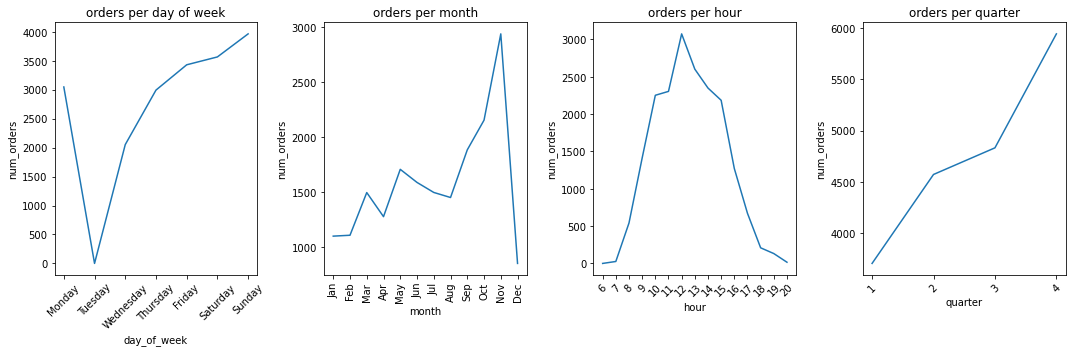

In [220]:
fig, ax = plt.subplots(1,4, figsize = (15,5))
ax_0 = sns.lineplot(ax = ax[0], data = unique_invoices_dow, x = 'day_of_week', y = 'num_orders')
ax_0.set_xticks(range(len(unique_invoices_dow['day_of_week'])))
ax_0.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday'], rotation = 45)
ax_0.set_title('orders per day of week')
ax_1 = sns.lineplot(ax = ax[1], data = unique_invoices_month, x = 'month', y = 'num_orders')
ax_1.set_xticks(range(1, len(unique_invoices_month.index)+1))
ax_1.set_xticklabels(['Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], rotation = 90)
ax_1.set_title('orders per month')
ax_2 = sns.lineplot(ax = ax[2], data = unique_invoices_hour, x = 'hour', y = 'num_orders')
ax_2.set_xticks(range(6, len(unique_invoices_hour.index)+6))
ax_2.set_xticklabels(range(6, len(unique_invoices_hour.index)+6), rotation = 45)
ax_2.set_title('orders per hour')
ax_3 = sns.lineplot(ax = ax[3], data = unique_invoices_quarter, x = 'quarter', y = 'num_orders')
ax_3.set_xticks(range(1, len(unique_invoices_quarter['quarter'])+1))
ax_3.set_xticklabels(range(1, len(unique_invoices_quarter['quarter'])+1), rotation = 45)
ax_3.set_title('orders per quarter')


plt.tight_layout()
plt.show()

Note that in the graph for "orders per month", the num_orders drops suddenly in December. <br>
This is only because the 2019 data only goes up to 9 Dec. 

<h3> Some More Aggregation dataframes </h3>

Group by: 

day_of_week <br>
hour  <br>
month <br>
country


In [221]:
# Group by day of week
df_dow = merged_table.groupby(['day_of_week']).agg({'invoice_no':'nunique', 'total_sale':['mean', 'sum'], 
                                                'customer_id':'nunique', 'quantity': ['mean', 'sum']})

df_dow['num_orders']=df_dow['invoice_no']['nunique']
df_dow['total_sale_mean']=df_dow['total_sale']['mean']
df_dow['total_revenue']=df_dow['total_sale']['sum']
df_dow['num_unique_customers']= df_dow['customer_id']['nunique']
df_dow['units_sold_mean'] = df_dow['quantity']['mean']
df_dow['total_units_sold'] = df_dow['quantity']['sum']

df_dow = df_dow[['num_orders', 'total_revenue', 'num_unique_customers', 'total_units_sold']]
df_dow = df_dow.reset_index()

df_dow.loc['6'] = [1,0,0,0,0]
df_dow = df_dow.sort_values('day_of_week')
df_dow.index = [0,1,2,3,4,5,6]


# Group by hour
df_hour = merged_table.groupby(['hour']).agg({'invoice_no':'nunique', 'total_sale':['mean', 'sum'], 
                                                'customer_id':'nunique', 'quantity': ['mean', 'sum']})
df_hour['num_orders']=df_hour['invoice_no']['nunique']
df_hour['total_sale_mean']=df_hour['total_sale']['mean']
df_hour['total_revenue']=df_hour['total_sale']['sum']
df_hour['num_unique_customers']= df_hour['customer_id']['nunique']
df_hour['units_sold_mean'] = df_hour['quantity']['mean']
df_hour['total_units_sold'] = df_hour['quantity']['sum']

df_hour = df_hour[['num_orders', 'total_revenue', 'num_unique_customers', 'total_units_sold']]
df_hour = df_hour.reset_index()


# Group by month
df_month = merged_table.groupby(['month']).agg({'invoice_no':'nunique', 'total_sale':['mean', 'sum'], 
                                                'customer_id':'nunique', 'quantity': ['mean', 'sum']})
df_month['num_orders']=df_month['invoice_no']['nunique']
df_month['total_sale_mean']=df_month['total_sale']['mean']
df_month['total_revenue']=df_month['total_sale']['sum']
df_month['num_unique_customers']= df_month['customer_id']['nunique']
df_month['units_sold_mean'] = df_month['quantity']['mean']
df_month['total_units_sold'] = df_month['quantity']['sum']

df_month = df_month[['num_orders', 'total_revenue', 'num_unique_customers', 'total_units_sold']]
df_month = df_month.reset_index()

# Group by invoice_date
df_date = merged_table.groupby(['invoice_date']).agg({'invoice_no':'nunique', 'total_sale':['mean', 'sum'], 
                                                'customer_id':'nunique', 'quantity': ['mean', 'sum']})
df_date['num_orders']=df_date['invoice_no']['nunique']
df_date['total_sale_mean']=df_date['total_sale']['mean']
df_date['total_revenue']=df_date['total_sale']['sum']
df_date['num_unique_customers']= df_date['customer_id']['nunique']
df_date['units_sold_mean'] = df_date['quantity']['mean']
df_date['total_units_sold'] = df_date['quantity']['sum']

df_date = df_date[['num_orders', 'total_revenue', 'num_unique_customers', 'total_units_sold']]
df_date = df_date.reset_index()


# Group by country
df_country = merged_table.groupby(['country']).agg({'invoice_no':'nunique', 'total_sale':['mean', 'sum'], 
                                                'customer_id':'nunique', 'quantity': ['mean', 'sum']})
df_country['num_orders']=df_country['invoice_no']['nunique']
df_country['total_sale_mean']=df_country['total_sale']['mean']
df_country['total_revenue']=df_country['total_sale']['sum']
df_country['num_unique_customers']= df_country['customer_id']['nunique']
df_country['units_sold_mean'] = df_country['quantity']['mean']
df_country['total_units_sold'] = df_country['quantity']['sum']

df_country = df_country[['num_orders', 'total_revenue', 'num_unique_customers', 'total_units_sold']]
df_country.sort_values(by = ['total_revenue', 'num_orders', 'num_unique_customers'],ascending = False, inplace = True)
df_country['revenue_per_customer'] = df_country['total_revenue'] / df_country['num_unique_customers']
df_country['revenue_per_order'] = df_country['total_revenue'] / df_country['num_orders']
df_country = df_country.reset_index()

In [222]:
# Group by customer

df_customer = merged_table.groupby(['customer_id']).agg({'invoice_no':'nunique', 'total_sale':'sum', 
                                                    'product_id': 'nunique', 'unit_price':'mean',
                                                     'quantity': ['mean', 'sum']})

df_customer['num_orders'] = df_customer['invoice_no']['nunique']
df_customer['total_revenue'] = df_customer['total_sale']['sum']
df_customer['num_unique_products'] = df_customer['product_id']['nunique']
df_customer['avg_unit_price'] = df_customer['unit_price']['mean']
df_customer['total_units_sold'] = df_customer['quantity']['sum']


df_customer = df_customer[['num_orders','total_revenue','num_unique_products','avg_unit_price','total_units_sold']].reset_index().sort_values(by='total_revenue',ascending=False)
df_customer.drop(4339, axis = 0,inplace = True) # drop row where customer_id = Null
df_customer

,customer_id,num_orders,total_revenue,num_unique_products,avg_unit_price,total_units_sold
,,,,,,
1690,14646,73,21664738.30,707,96.933489,205535
1880,14911,201,9340224.33,1790,97.530018,83711
55,12415,20,9244349.18,442,106.143735,80119
3729,17450,46,9061246.11,123,97.376657,70185
4202,18102,60,8114485.22,162,123.187740,72321
...,...,...,...,...,...,...
353,12789,1,35.97,3,11.990000,3
2639,15940,1,31.96,1,7.990000,4
4325,18268,1,23.98,1,11.990000,2


In [223]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4339 entries, 1690 to 825
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   (customer_id, )          4339 non-null   object 
 1   (num_orders, )           4339 non-null   int64  
 2   (total_revenue, )        4339 non-null   float64
 3   (num_unique_products, )  4339 non-null   int64  
 4   (avg_unit_price, )       4339 non-null   float64
 5   (total_units_sold, )     4339 non-null   int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 237.3+ KB


The columns are currently tuples. Want to retrieve only 0th element of each tuple.

In [224]:
df_customer.columns = [tup[0] for tup in df_customer.columns]
df_customer.columns

Index(['customer_id', 'num_orders', 'total_revenue', 'num_unique_products',
       'avg_unit_price', 'total_units_sold'],
      dtype='object')

In [225]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4339 entries, 1690 to 825
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer_id          4339 non-null   object 
 1   num_orders           4339 non-null   int64  
 2   total_revenue        4339 non-null   float64
 3   num_unique_products  4339 non-null   int64  
 4   avg_unit_price       4339 non-null   float64
 5   total_units_sold     4339 non-null   int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 237.3+ KB


We also want to add the customer country to df_customer. Do a left join.

In [226]:
dummy = merged_table[['customer_id', 'country']].drop_duplicates()

In [227]:
df_customer = pd.merge(df_customer, dummy, on = 'customer_id', how = 'left', copy = False)

In [228]:
df_customer.head()

,customer_id,num_orders,total_revenue,num_unique_products,avg_unit_price,total_units_sold,country
0,14646,73,21664738.30,707,96.933489,205535,Netherlands
1,14911,201,9340224.33,1790,97.530018,83711,Ireland
2,12415,20,9244349.18,442,106.143735,80119,Australia
3,17450,46,9061246.11,123,97.376657,70185,Germany
4,18102,60,8114485.22,162,123.187740,72321,Germany


<h3> Check all aggragated dataframes </h3>

In [229]:
df_dow.head()


,day_of_week,num_orders,total_revenue,num_unique_customers,total_units_sold
,,,,,
0,0,3261,9.408201e+07,1557,963163
1,1,0,0.000000e+00,0,0
2,2,2207,5.159529e+07,1226,491458
3,3,3231,9.653663e+07,1594,952158
4,4,3660,1.213098e+08,1698,1219801


In [230]:
df_hour.head()


,hour,num_orders,total_revenue,num_unique_customers,total_units_sold
,,,,,
0,6,1,279.00,1,1
1,7,29,1432988.69,28,15929
2,8,568,17271226.68,427,166016
3,9,1517,52760504.55,888,542119
4,10,2430,85651605.63,1263,888876


In [231]:
df_month.head()


,month,num_orders,total_revenue,num_unique_customers,total_units_sold
,,,,,
0,1,1100,38126912.27,742,407747
1,2,1108,29315803.02,759,300844
2,3,1496,42474432.75,975,422550
3,4,1276,32697661.49,855,328131
4,5,1707,41226715.35,1057,428100


In [232]:
df_date.head()

,invoice_date,num_orders,total_revenue,num_unique_customers,total_units_sold
,,,,,
0,2018-12-01,127,3752031.65,96,28360
1,2018-12-02,142,3234897.52,100,32749
2,2018-12-03,71,1564701.61,51,16945
3,2018-12-05,88,1737459.95,76,16886
4,2018-12-06,105,2741177.87,83,22700


In [233]:
df_country.head()

,country,num_orders,total_revenue,num_unique_customers,total_units_sold,revenue_per_customer,revenue_per_order
,,,,,,,
0,Germany,18709,5.177474e+08,3922,5062416,1.320111e+05,27673.709838
1,Netherlands,94,2.200264e+07,9,209202,2.444738e+06,234070.655213
2,Ireland,288,1.588787e+07,4,153773,3.971968e+06,55166.222778
3,United Kingdom,478,1.238764e+07,103,133520,1.202683e+05,25915.562615
4,France,389,1.155420e+07,88,116332,1.312977e+05,29702.304524


In [234]:
df_customer.head()

,customer_id,num_orders,total_revenue,num_unique_products,avg_unit_price,total_units_sold,country
0,14646,73,21664738.30,707,96.933489,205535,Netherlands
1,14911,201,9340224.33,1790,97.530018,83711,Ireland
2,12415,20,9244349.18,442,106.143735,80119,Australia
3,17450,46,9061246.11,123,97.376657,70185,Germany
4,18102,60,8114485.22,162,123.187740,72321,Germany


six dataframes: <br>
dow, month, hour, date, country, customer_id <br>

<h3> Day of week </h3>

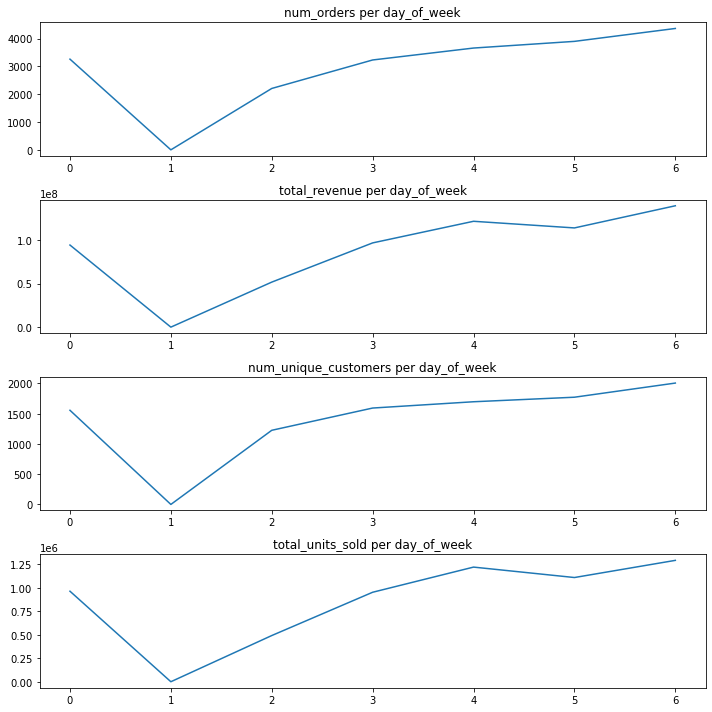

In [235]:
variables = ['num_orders', 'total_revenue', 'num_unique_customers', 'total_units_sold']


fig, ax = plt.subplots(4,1, figsize = (10,10))
for i, var in enumerate (variables):
    ax[i].plot(df_dow['day_of_week'], df_dow[var])
    ax[i].set_title (f'{var} per day_of_week')
    
plt.tight_layout()
plt.show()

<h3> Month </h3>

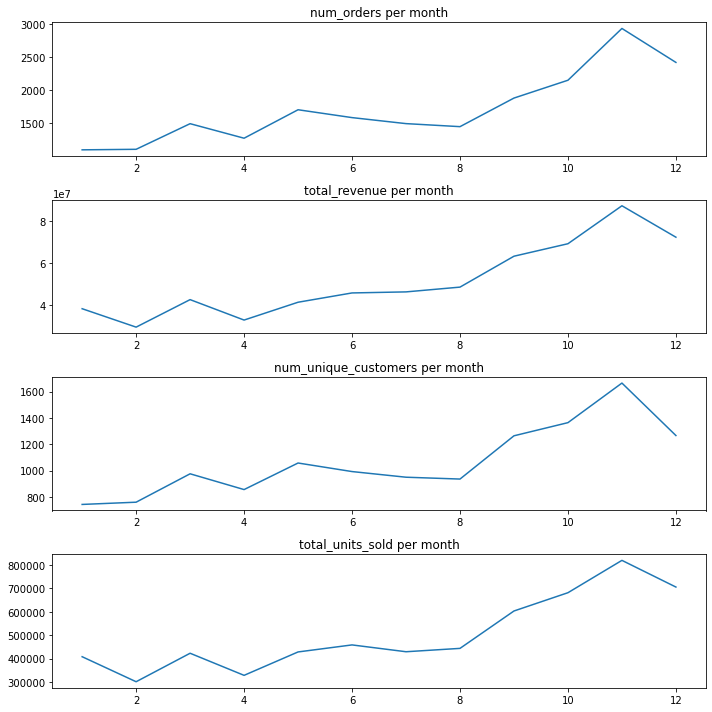

In [236]:
variables = ['num_orders', 'total_revenue', 'num_unique_customers', 'total_units_sold']


fig, ax = plt.subplots(4,1, figsize = (10,10))
for i, var in enumerate (variables):
    ax[i].plot(df_month['month'], df_month[var])
    ax[i].set_title (f'{var} per month')
    
plt.tight_layout()
plt.show()

<h3> Hour </h3>

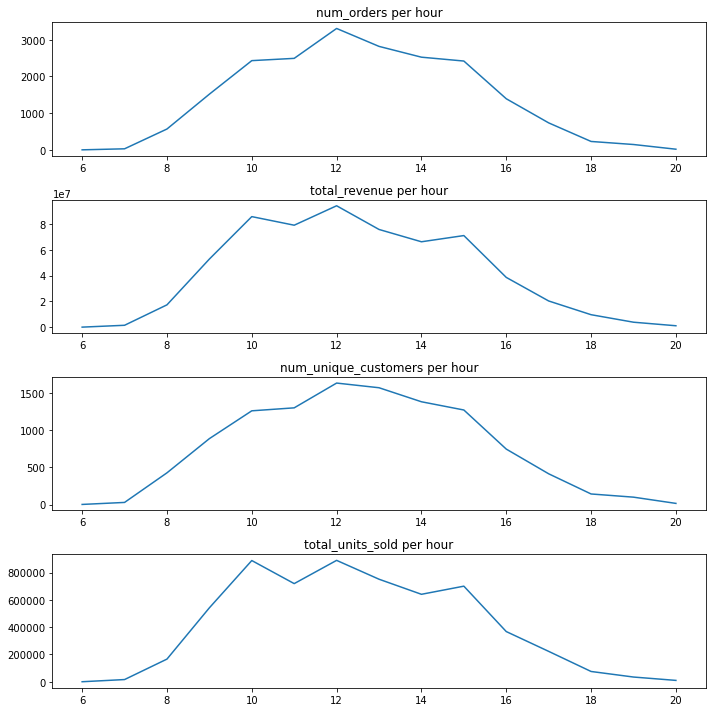

In [237]:
variables = ['num_orders', 'total_revenue', 'num_unique_customers', 'total_units_sold']


fig, ax = plt.subplots(4,1, figsize = (10,10))
for i, var in enumerate (variables):
    ax[i].plot(df_hour['hour'], df_hour[var])
    ax[i].set_title (f'{var} per hour')
    
plt.tight_layout()
plt.show()

<h3> Invoice date </h3>

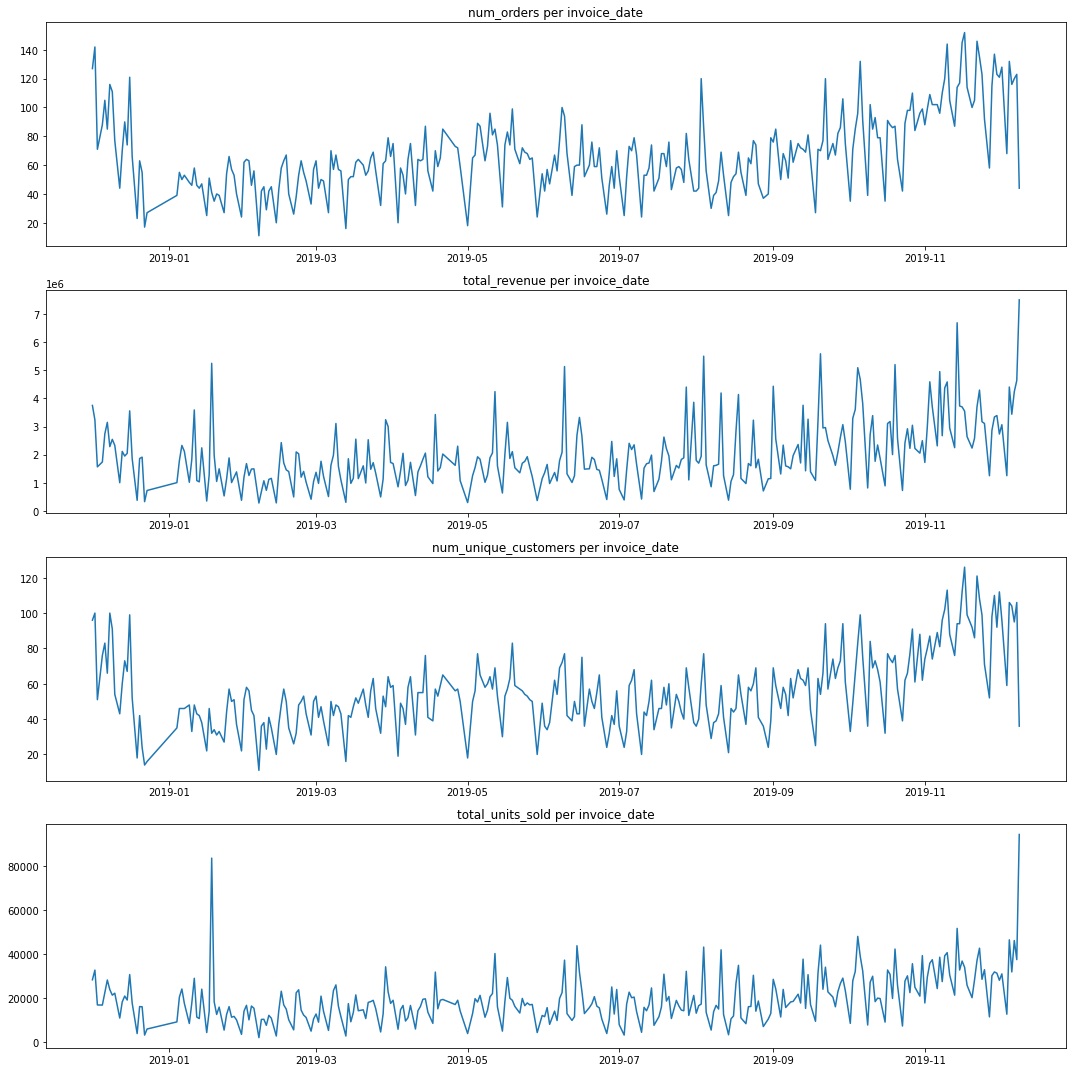

In [266]:
variables = ['num_orders', 'total_revenue', 'num_unique_customers', 'total_units_sold']


fig, ax = plt.subplots(4,1, figsize = (15,15))
for i, var in enumerate (variables):
    ax[i].plot(df_date['invoice_date'], df_date[var])
    ax[i].set_title (f'{var} per invoice_date')
    
plt.tight_layout()
plt.show()



<h3> Country </h3>

/var/folders/68/lmdx_4hd4msbstk8y2t5phyh0000gn/T/ipykernel_76872/1579644346.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(labels = df_country[(df_country['total_revenue']>100000) & (df_country['country']!= 'Germany')]['country'], rotation = 90)
/var/folders/68/lmdx_4hd4msbstk8y2t5phyh0000gn/T/ipykernel_76872/1579644346.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(labels = df_country[(df_country['total_revenue']>100000) & (df_country['country']!= 'Germany')]['country'], rotation = 90)
/var/folders/68/lmdx_4hd4msbstk8y2t5phyh0000gn/T/ipykernel_76872/1579644346.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(labels = df_country[(df_country['total_revenue']>100000) & (df_country['country']!= 'Germany')]['country'], rotation = 90)
/var/folders/68/lmdx_4hd4msbstk8y2t5phyh0000gn/T/ipykernel_76872/1579644346.py:9: UserWa

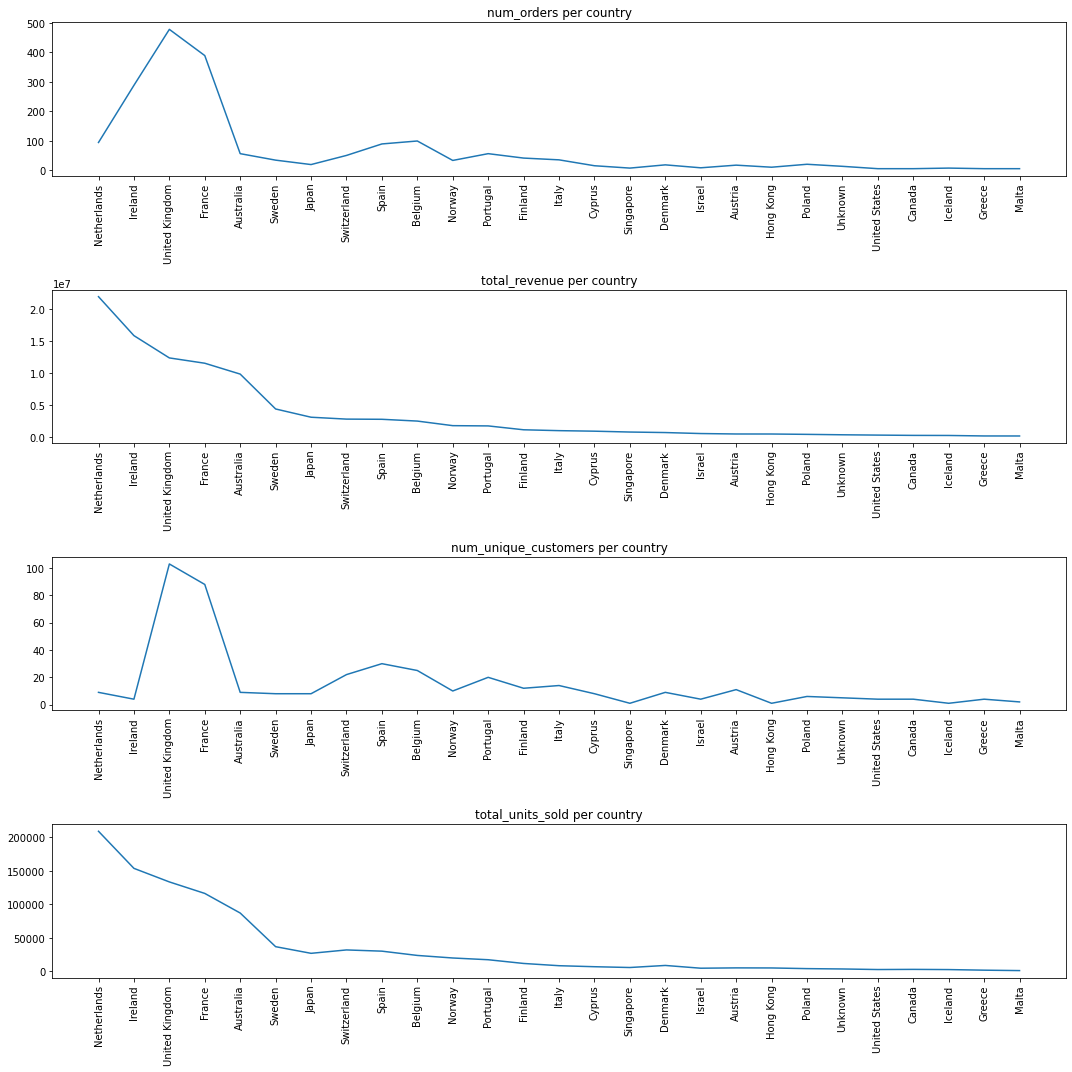

In [239]:
variables = ['num_orders', 'total_revenue', 'num_unique_customers', 'total_units_sold']


fig, ax = plt.subplots(4,1, figsize = (15,15))
for i, var in enumerate (variables):
    ax[i].plot(df_country[(df_country['total_revenue']>100000) & (df_country['country']!= 'Germany')]['country'],   # Exclude Germany
                df_country[(df_country['total_revenue']>100000) & (df_country['country']!= 'Germany')][var])
    ax[i].set_title (f'{var} per country')
    ax[i].set_xticklabels(labels = df_country[(df_country['total_revenue']>100000) & (df_country['country']!= 'Germany')]['country'], rotation = 90)
    
plt.tight_layout()
plt.show()



<h5> Focus on top 10 countries </h5>

In [240]:
top_10_countries = df_country.sort_values(by = 'total_revenue', ascending = False).head(11)
# Exclude Germany
top_10_countries.drop(0, axis = 0, inplace = True)
top_10_countries

,country,num_orders,total_revenue,num_unique_customers,total_units_sold,revenue_per_customer,revenue_per_order
,,,,,,,
1,Netherlands,94,22002641.59,9,209202,2.444738e+06,234070.655213
2,Ireland,288,15887872.16,4,153773,3.971968e+06,55166.222778
3,United Kingdom,478,12387638.93,103,133520,1.202683e+05,25915.562615
4,France,389,11554196.46,88,116332,1.312977e+05,29702.304524
5,Australia,56,9848728.98,9,87033,1.094303e+06,175870.160357
6,Sweden,34,4373181.09,8,36760,5.466476e+05,128622.973235
7,Japan,19,3078620.22,8,26828,3.848275e+05,162032.643158
8,Switzerland,50,2782128.65,22,31893,1.264604e+05,55642.573000
9,Spain,89,2754244.31,30,30061,9.180814e+04,30946.565281


/var/folders/68/lmdx_4hd4msbstk8y2t5phyh0000gn/T/ipykernel_76872/2681899901.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(labels = top_10_countries['country'], rotation = 45)
/var/folders/68/lmdx_4hd4msbstk8y2t5phyh0000gn/T/ipykernel_76872/2681899901.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(labels = top_10_countries['country'], rotation = 45)
/var/folders/68/lmdx_4hd4msbstk8y2t5phyh0000gn/T/ipykernel_76872/2681899901.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(labels = top_10_countries['country'], rotation = 45)


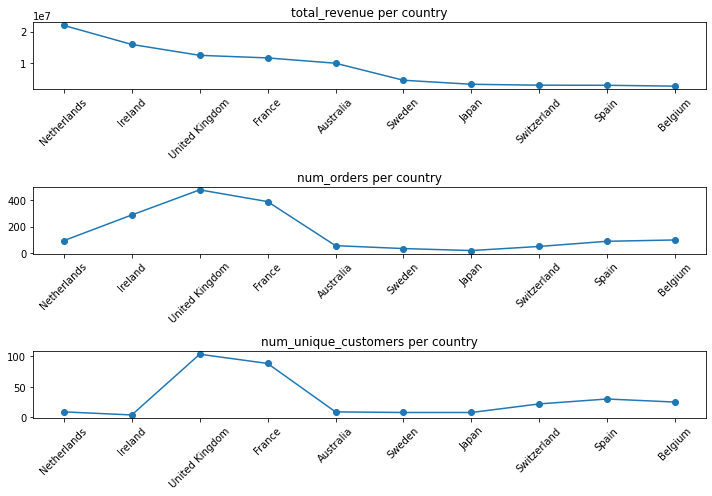

In [241]:
variables = [ 'total_revenue', 'num_orders', 'num_unique_customers']


fig, ax = plt.subplots(3,1, figsize = (10,7))
for i, var in enumerate (variables):
    ax[i].plot(top_10_countries['country'], 
                top_10_countries[var], marker = 'o')
    ax[i].set_title (f'{var} per country')
    ax[i].set_xticklabels(labels = top_10_countries['country'], rotation = 45)
    
plt.tight_layout()
plt.show()

<h3> Revenue per order & revenue per unique customer </h3>

In [242]:
top_10_countries['rev_per_order'] = top_10_countries['total_revenue'] / top_10_countries['num_orders']
top_10_countries['rev_per_customer'] = top_10_countries['total_revenue'] / top_10_countries['num_unique_customers']
top_10_countries


,country,num_orders,total_revenue,num_unique_customers,total_units_sold,revenue_per_customer,revenue_per_order,rev_per_order,rev_per_customer
,,,,,,,,,
1,Netherlands,94,22002641.59,9,209202,2.444738e+06,234070.655213,234070.655213,2.444738e+06
2,Ireland,288,15887872.16,4,153773,3.971968e+06,55166.222778,55166.222778,3.971968e+06
3,United Kingdom,478,12387638.93,103,133520,1.202683e+05,25915.562615,25915.562615,1.202683e+05
4,France,389,11554196.46,88,116332,1.312977e+05,29702.304524,29702.304524,1.312977e+05
5,Australia,56,9848728.98,9,87033,1.094303e+06,175870.160357,175870.160357,1.094303e+06
6,Sweden,34,4373181.09,8,36760,5.466476e+05,128622.973235,128622.973235,5.466476e+05
7,Japan,19,3078620.22,8,26828,3.848275e+05,162032.643158,162032.643158,3.848275e+05
8,Switzerland,50,2782128.65,22,31893,1.264604e+05,55642.573000,55642.573000,1.264604e+05
9,Spain,89,2754244.31,30,30061,9.180814e+04,30946.565281,30946.565281,9.180814e+04


/var/folders/68/lmdx_4hd4msbstk8y2t5phyh0000gn/T/ipykernel_76872/1750308647.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(labels = top_10_countries['country'], rotation = 45)
/var/folders/68/lmdx_4hd4msbstk8y2t5phyh0000gn/T/ipykernel_76872/1750308647.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(labels = top_10_countries['country'], rotation = 45)
/var/folders/68/lmdx_4hd4msbstk8y2t5phyh0000gn/T/ipykernel_76872/1750308647.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(labels = top_10_countries['country'], rotation = 45)


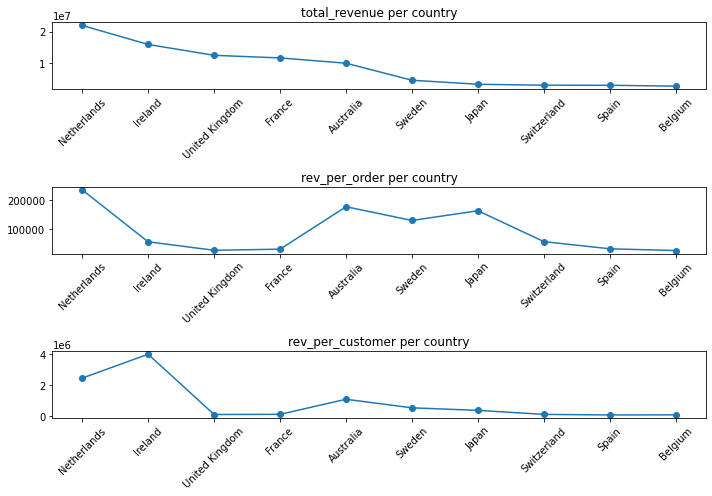

In [243]:
variables = ['total_revenue', 'rev_per_order', 'rev_per_customer']

fig, ax = plt.subplots(len(variables),1, figsize = (10,7))
for i, var in enumerate (variables):
    ax[i].plot(top_10_countries['country'], 
                top_10_countries[var], marker = 'o')
    ax[i].set_title (f'{var} per country')
    ax[i].set_xticklabels(labels = top_10_countries['country'], rotation = 45)
    
plt.tight_layout()
plt.show()

First graph: which countries have customers making bulk orders? (Netherlands, Australia, Sweden, Japan) <br>
Second graph: which countries have small number of customers making large sum of purchases? (Netherlands, Ireland, Australia)

<h3> Days in 2019 with unusual peaks and troughs in total_revenue </h3>

In [244]:
df_date.head()

,invoice_date,num_orders,total_revenue,num_unique_customers,total_units_sold
,,,,,
0,2018-12-01,127,3752031.65,96,28360
1,2018-12-02,142,3234897.52,100,32749
2,2018-12-03,71,1564701.61,51,16945
3,2018-12-05,88,1737459.95,76,16886
4,2018-12-06,105,2741177.87,83,22700


To locate unusual peaks: <br>
Add column for the "rolling mean" and column for "total revenue - rolling mean"

In [245]:
df_date ['total_revenue_rolling_mean'] = df_date['total_revenue'].rolling(5, center= True).mean()       # mean of current date + previous date + following date
df_date['total_revenue_minus_mean'] = df_date ['total_revenue'] - df_date ['total_revenue_rolling_mean'] # current value - mean value

In [246]:
# Convert invoice_date column to datetime format
df_date['invoice_date'] = pd.to_datetime(df_date['invoice_date'])

Select top 20 rows

In [247]:
high_rev_dates = df_date[df_date['invoice_date'].dt.year == 2019].sort_values(by = 'total_revenue_minus_mean', ascending = False).head(20)[['invoice_date', 'total_revenue']]

Select bottom 20 rows

In [248]:
low_rev_dates = df_date[df_date['invoice_date'].dt.year == 2019].sort_values(by = 'total_revenue_minus_mean', ascending = True).head(20)[['invoice_date', 'total_revenue']]

In [249]:
weekends_2019 = df_date [(df_date['invoice_date'].dt.day_name() == 'Saturday') | (df_date['invoice_date'].dt.day_name() == 'Sunday')]
weekends_2019 = weekends_2019[weekends_2019['invoice_date'].dt.year == 2019]
weekends_2019 = weekends_2019 [['invoice_date','total_revenue']]

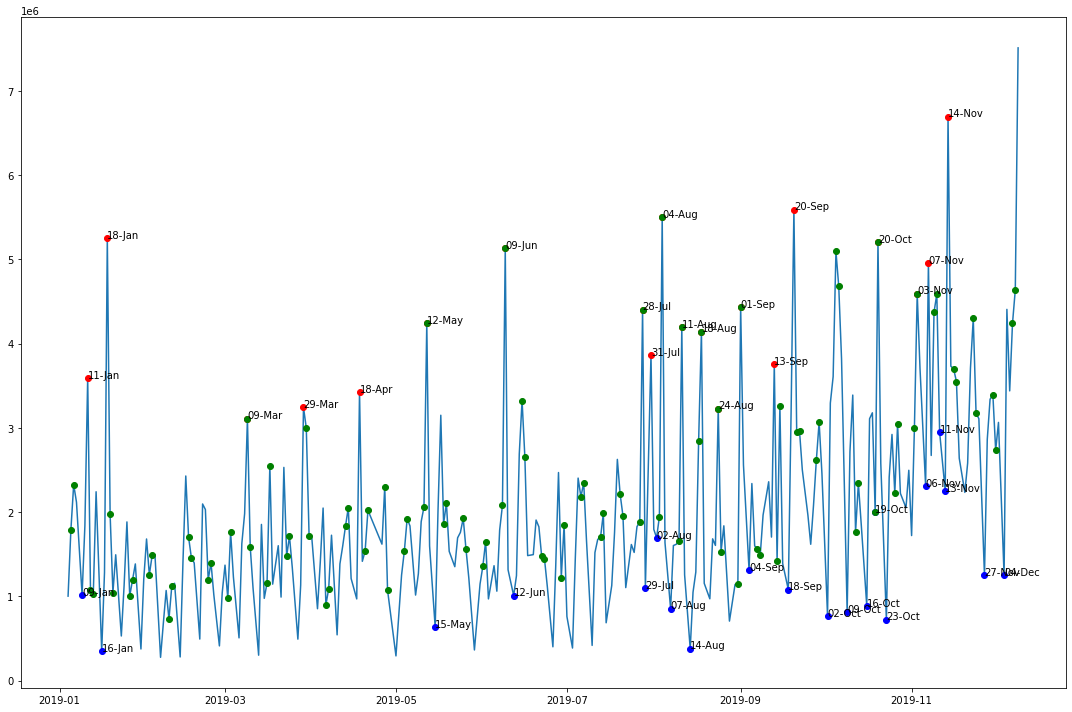

In [250]:
x = high_rev_dates ['invoice_date']
y = high_rev_dates ['total_revenue']

a = low_rev_dates ['invoice_date']
b = low_rev_dates ['total_revenue']

m = weekends_2019['invoice_date']
n = weekends_2019['total_revenue']


df_date_2019 = df_date [df_date['invoice_date'].dt.year == 2019]

plt.figure(figsize = (15,10))
plt.plot (df_date_2019['invoice_date'], df_date_2019['total_revenue'])
for xy in zip (x,y):
    plt.plot(xy[0], xy[1], color = 'r', marker = 'o')
    plt.annotate(f'{xy[0].strftime("%d-%b")}', xy = xy)

for ab in zip (a,b):
    plt.plot(ab[0], ab[1], color = 'b', marker = 'o')
    plt.annotate(f'{ab[0].strftime("%d-%b")}', xy = ab)

for mn in zip (m,n):
    plt.plot(mn[0], mn[1], color = 'g', marker = 'o')
    #plt.annotate(f'{mn[0].strftime("%d-%b")}', xy = mn)

plt.tight_layout()
plt.show()

Green dots with no date: weekends <br>
Green dots with no date: weekends + unusually high sales

Notice that regardless of the "red dot" locations, most of the local maxima have a green dot

<h3> Histogram of total_revenue for each customer_id </h3>

In [251]:
df_customer.head()

,customer_id,num_orders,total_revenue,num_unique_products,avg_unit_price,total_units_sold,country
0,14646,73,21664738.30,707,96.933489,205535,Netherlands
1,14911,201,9340224.33,1790,97.530018,83711,Ireland
2,12415,20,9244349.18,442,106.143735,80119,Australia
3,17450,46,9061246.11,123,97.376657,70185,Germany
4,18102,60,8114485.22,162,123.187740,72321,Germany


In [252]:
temp = df_customer.groupby(['country', 'customer_id'])['total_revenue'].sum().reset_index()

In [253]:
# Get list of countries with top 10 revenue (exlcuding Germany)
top_10_list = top_10_countries['country'].tolist()

# Add Germany
#top_10_list.append('Germany')

top_10_list

['Netherlands',
 'Ireland',
 'United Kingdom',
 'France',
 'Australia',
 'Sweden',
 'Japan',
 'Switzerland',
 'Spain',
 'Belgium']

In [254]:
customers_per_country = []
for country in top_10_list:
    customers_per_country.append(temp [temp['country']==country])


In [255]:
len(customers_per_country)

10

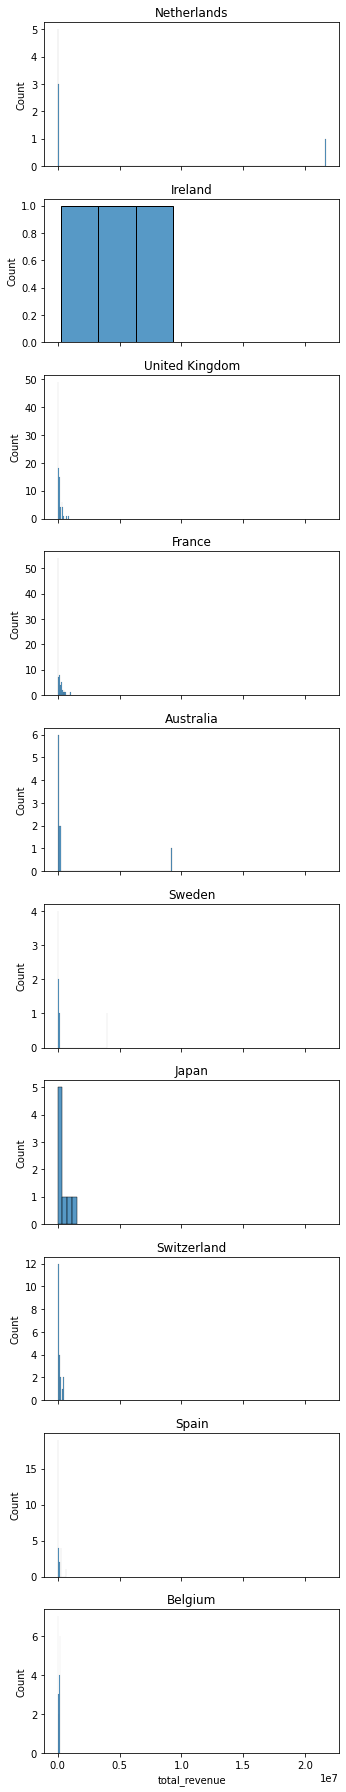

In [256]:
fig, ax = plt.subplots(10,1, figsize = (5,25), sharex = True)
for i, df in enumerate(customers_per_country):
    sns.histplot(ax = ax[i], data = df, x = 'total_revenue')
    ax[i].set_title(f'{top_10_list[i]}')

plt.tight_layout()
plt.show()


OK so grouping by country clearly doesn't show much.

In [257]:
df_customer.describe()

,num_orders,total_revenue,num_unique_products,avg_unit_price,total_units_sold
count,4347.000000,4.347000e+03,4347.000000,4347.000000,4347.000000
mean,4.282954,1.277652e+05,61.468599,100.222271,1243.645043
std,7.720675,5.575827e+05,85.163007,48.302940,5238.572877
min,1.000000,1.398000e+01,1.000000,6.990000,1.000000
25%,1.000000,1.471622e+04,16.000000,77.402000,167.000000
50%,2.000000,3.921182e+04,35.000000,94.961163,400.000000
75%,5.000000,1.032755e+05,78.000000,114.518495,1039.000000
max,211.000000,2.166474e+07,1790.000000,833.250000,205535.000000


The summary statistics tell us why. The standard deviation for total_revenue is enormous. So is the gap between min and max

<h3> Group by product </h3>

In [258]:
merged_table.head()

,invoice_no,product_id,quantity,unit_price,total_sale,customer_id,rating,review_count,country,product_name,product_type,stock_code,invoice_datetime,day_of_week,month,hour,year,quarter,invoice_date
0,78536597,B07GWKDLGT,4,496.95,1987.80,18011,4.6,1399,Germany,Nikon D3500 W/ AF-P DX NIKKOR 18-55mm f/3.5-5....,dslr camera,21703,2018-12-01 17:00:00,5,12,17,2018,4,2018-12-01
1,78536597,B01MTLH408,4,39.99,159.96,18011,4.6,289,Germany,"Manfrotto Element Aluminum 5-Section Monopod, ...",dslr camera,40001,2018-12-01 17:00:00,5,12,17,2018,4,2018-12-01
2,78536597,B0064FS7HI,1,12.99,12.99,18011,4.4,333,Germany,"STK LP-E8 Battery for Canon Rebel T5i, T3i, T2...",dslr camera,85034A,2018-12-01 17:00:00,5,12,17,2018,4,2018-12-01
3,78536597,B013JHU5YG,1,199.99,199.99,18011,4.3,86,Germany,Lowepro Whistler BP 350 AW (Grey) . Profession...,dslr camera,72798C,2018-12-01 17:00:00,5,12,17,2018,4,2018-12-01
4,78536597,B06XWN9Q99,1,7.49,7.49,18011,4.7,15717,Germany,Samsung (MB-ME32GA/AM) 32GB 95MB/s (U1) microS...,dslr camera,20726,2018-12-01 17:00:00,5,12,17,2018,4,2018-12-01


In [259]:
top_products = merged_table.groupby('product_id')['quantity', 'total_sale'].sum().reset_index().sort_values(by = 'total_sale', ascending = False)
top_products.head(30)
top_products.drop(top_products [top_products['product_id'] == 'Null'].index, inplace = True)
top_products.head(10)

/var/folders/68/lmdx_4hd4msbstk8y2t5phyh0000gn/T/ipykernel_76872/3748862956.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  top_products = merged_table.groupby('product_id')['quantity', 'total_sale'].sum().reset_index().sort_values(by = 'total_sale', ascending = False)


,product_id,quantity,total_sale
2052,B079JSZ1Z2,48478,27327048.60
3890,B081TJ7B88,37895,19288555.00
2871,B07NZX5BKH,13890,9271575.00
1770,B07598VZR8,26339,9217596.44
23,B00009R6WO,13882,9009418.00
2109,B07BFNDPJ5,17608,8557311.92
3687,B07Y8Y6HVW,36461,7802654.00
1325,B01M4II4M4,18299,7301301.00
3354,B07TWFWJDZ,36419,7245560.05
4103,B087RTV311,11656,6410683.44


Select unique product_id + product_name pairs

In [260]:
product_names = merged_table.drop_duplicates(subset = ['product_id', 'product_name', 'product_type'])
product_names = product_names[['product_id','product_name', 'product_type']]
product_names

,product_id,product_name,product_type
0,B07GWKDLGT,Nikon D3500 W/ AF-P DX NIKKOR 18-55mm f/3.5-5....,dslr camera
1,B01MTLH408,"Manfrotto Element Aluminum 5-Section Monopod, ...",dslr camera
2,B0064FS7HI,"STK LP-E8 Battery for Canon Rebel T5i, T3i, T2...",dslr camera
3,B013JHU5YG,Lowepro Whistler BP 350 AW (Grey) . Profession...,dslr camera
4,B06XWN9Q99,Samsung (MB-ME32GA/AM) 32GB 95MB/s (U1) microS...,dslr camera
...,...,...,...
545665,B07YBS9PGN,"2019 14"" Laptop - Intel Quad-Core Atom x5 E800...",keyboard
546296,B07RPVG1PD,SANWA (Japan Brand) Gel Wrist Rest for Keyboar...,mouse
546724,B07YBS9PGN,"2019 14"" Laptop - Intel Quad-Core Atom x5 E800...",processor
550073,B075TVH3YK,HESPLUS Protective Storage Case Compatible wit...,mouse


In [261]:
top_products['unit_price'] = top_products['total_sale'] / top_products['quantity']
top_products

,product_id,quantity,total_sale,unit_price
2052,B079JSZ1Z2,48478,27327048.60,563.70
3890,B081TJ7B88,37895,19288555.00,509.00
2871,B07NZX5BKH,13890,9271575.00,667.50
1770,B07598VZR8,26339,9217596.44,349.96
23,B00009R6WO,13882,9009418.00,649.00
...,...,...,...,...
1223,B01J3DVRFG,1,7.99,7.99
2818,B07N496KJ4,1,7.99,7.99
2112,B07BGQYWWQ,1,7.98,7.98
2597,B07JL6G69Q,1,6.88,6.88


In [262]:
top_products = pd.merge(top_products, product_names, on = 'product_id', how = 'left')

In [263]:
top_products.head(10)

,product_id,quantity,total_sale,unit_price,product_name,product_type
0,B079JSZ1Z2,48478,27327048.60,563.70,Samsung Galaxy S9 G960U 64GB Unlocked 4G LTE P...,smartphone
1,B081TJ7B88,37895,19288555.00,509.00,"Apple iPhone X, 256GB, Silver - Fully Unlocked...",smartphone
2,B07NZX5BKH,13890,9271575.00,667.50,Samsung Galaxy S10+ Plus 128GB+8GB RAM SM-G975...,smartphone
3,B07598VZR8,26339,9217596.44,349.96,Intel Core i7-8700K Desktop Processor 6 Cores ...,processor
4,B00009R6WO,13882,9009418.00,649.00,Canon EF 17-40mm f/4L USM Ultra Wide Angle Zoo...,dslr camera
5,B07BFNDPJ5,17608,8557311.92,485.99,(Renewed) Latest Microsoft Surface Pro 4 (2736...,processor
6,B07Y8Y6HVW,36461,7802654.00,214.00,"Xiaomi Redmi Note 8 Pro 64GB, 6GB RAM 6.53"" LT...",smartphone
7,B01M4II4M4,18299,7301301.00,399.00,ASUS ROG Swift PG248Q 24â€ Gaming Monitor Ful...,monitor
8,B07TWFWJDZ,36419,7245560.05,198.95,Fitbit Versa 2 Health and Fitness Smartwatch w...,smartphone
9,B087RTV311,11656,6410683.44,549.99,"Acer Aspire 5 A515-55-56VK, 15.6"" Full HD IPS ...",keyboard


<h3> Top N revenue generating products </h3>

In [264]:
N = 20
top_products.sort_values(by = 'total_sale', ascending = False).head(N)

,product_id,quantity,total_sale,unit_price,product_name,product_type
0,B079JSZ1Z2,48478,27327048.60,563.70,Samsung Galaxy S9 G960U 64GB Unlocked 4G LTE P...,smartphone
1,B081TJ7B88,37895,19288555.00,509.00,"Apple iPhone X, 256GB, Silver - Fully Unlocked...",smartphone
2,B07NZX5BKH,13890,9271575.00,667.50,Samsung Galaxy S10+ Plus 128GB+8GB RAM SM-G975...,smartphone
3,B07598VZR8,26339,9217596.44,349.96,Intel Core i7-8700K Desktop Processor 6 Cores ...,processor
4,B00009R6WO,13882,9009418.00,649.00,Canon EF 17-40mm f/4L USM Ultra Wide Angle Zoo...,dslr camera
5,B07BFNDPJ5,17608,8557311.92,485.99,(Renewed) Latest Microsoft Surface Pro 4 (2736...,processor
6,B07Y8Y6HVW,36461,7802654.00,214.00,"Xiaomi Redmi Note 8 Pro 64GB, 6GB RAM 6.53"" LT...",smartphone
7,B01M4II4M4,18299,7301301.00,399.00,ASUS ROG Swift PG248Q 24â€ Gaming Monitor Ful...,monitor
8,B07TWFWJDZ,36419,7245560.05,198.95,Fitbit Versa 2 Health and Fitness Smartwatch w...,smartphone
9,B087RTV311,11656,6410683.44,549.99,"Acer Aspire 5 A515-55-56VK, 15.6"" Full HD IPS ...",keyboard


<h3> Top N selling products (by units sold) </h3>

In [265]:
N = 20
top_products.sort_values(by = 'quantity', ascending = False).head(N)

,product_id,quantity,total_sale,unit_price,product_name,product_type
11,B019PX7EGK,80995,6146710.55,75.89,CPB Heating Pad Compatible with iPad iPhone Sm...,smartphone
14,B07D99KFPL,78033,4661691.42,59.74,Seagate BarraCuda Pro 1TB Internal Hard Drive ...,processor
201,B081RF4VLM,55047,607718.88,11.04,"Adjustable Cell Phone Stand, Lamicall Phone St...",smartphone
0,B079JSZ1Z2,48478,27327048.60,563.70,Samsung Galaxy S9 G960U 64GB Unlocked 4G LTE P...,smartphone
101,B07Y693ND1,38706,1160792.94,29.99,Razer DeathAdder Essential Gaming Mouse: 6400 ...,mouse
100,B07Y693ND1,38706,1160792.94,29.99,Razer DeathAdder Essential Gaming Mouse: 6400 ...,keyboard
1,B081TJ7B88,37895,19288555.00,509.00,"Apple iPhone X, 256GB, Silver - Fully Unlocked...",smartphone
161,B00D76RNLS,36761,769407.73,20.93,"Manfrotto PIXI Mini Tripod, Black (MTPIXI-B)",dslr camera
6,B07Y8Y6HVW,36461,7802654.00,214.00,"Xiaomi Redmi Note 8 Pro 64GB, 6GB RAM 6.53"" LT...",smartphone
8,B07TWFWJDZ,36419,7245560.05,198.95,Fitbit Versa 2 Health and Fitness Smartwatch w...,smartphone
